# PROJECT PYTHON

## Парсинг данных

Цель нашего проекта - спарсить данные с сайта IMDb о 1000 фильмах из топ-1000 по рейтингу

#### Необходимо: 

1) Используя библиотеку requests, отправить GET-запрос на страницу 

2) Используя библиотеку Beautiful Soup, получить HTML-код страницы

3) Используя Beautiful Soup, извлечь необходимые данные о фильмах, их признаки для дальнейшего анализа

4) Сохранить полученные данные в файл в формате DataFrame для дальнейшего использования

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from time import sleep
from random import randint

In [2]:
# HTML-код
# 'https://www.imdb.com/search/title/?groups=top_1000'
# 'https://www.imdb.com/search/title/?groups=top_1000&start=51&ref_=adv_nxt'

In [3]:
# Здесь мы загружаем HTML-код постранично по URL-адресу url и проверяем статус-код ответа сервера. 
# Если статус-код равен 200, то это значит, что HTML-код успешно получен и мы можем продолжать парсинг.
for page in range(1, 1001, 50):
    url = f"https://www.imdb.com/search/title/?groups=top_1000&start={page}&ref_=adv_nxt"
    response = requests.get(url)
response

<Response [200]>

In [4]:
#парсим содержимое ответа от сервера (response.content) в формате HTML 
soup = BeautifulSoup(response.content, 'html.parser')

#### Скрин кода страницы с выделенными некоторыми необходимыми признаками

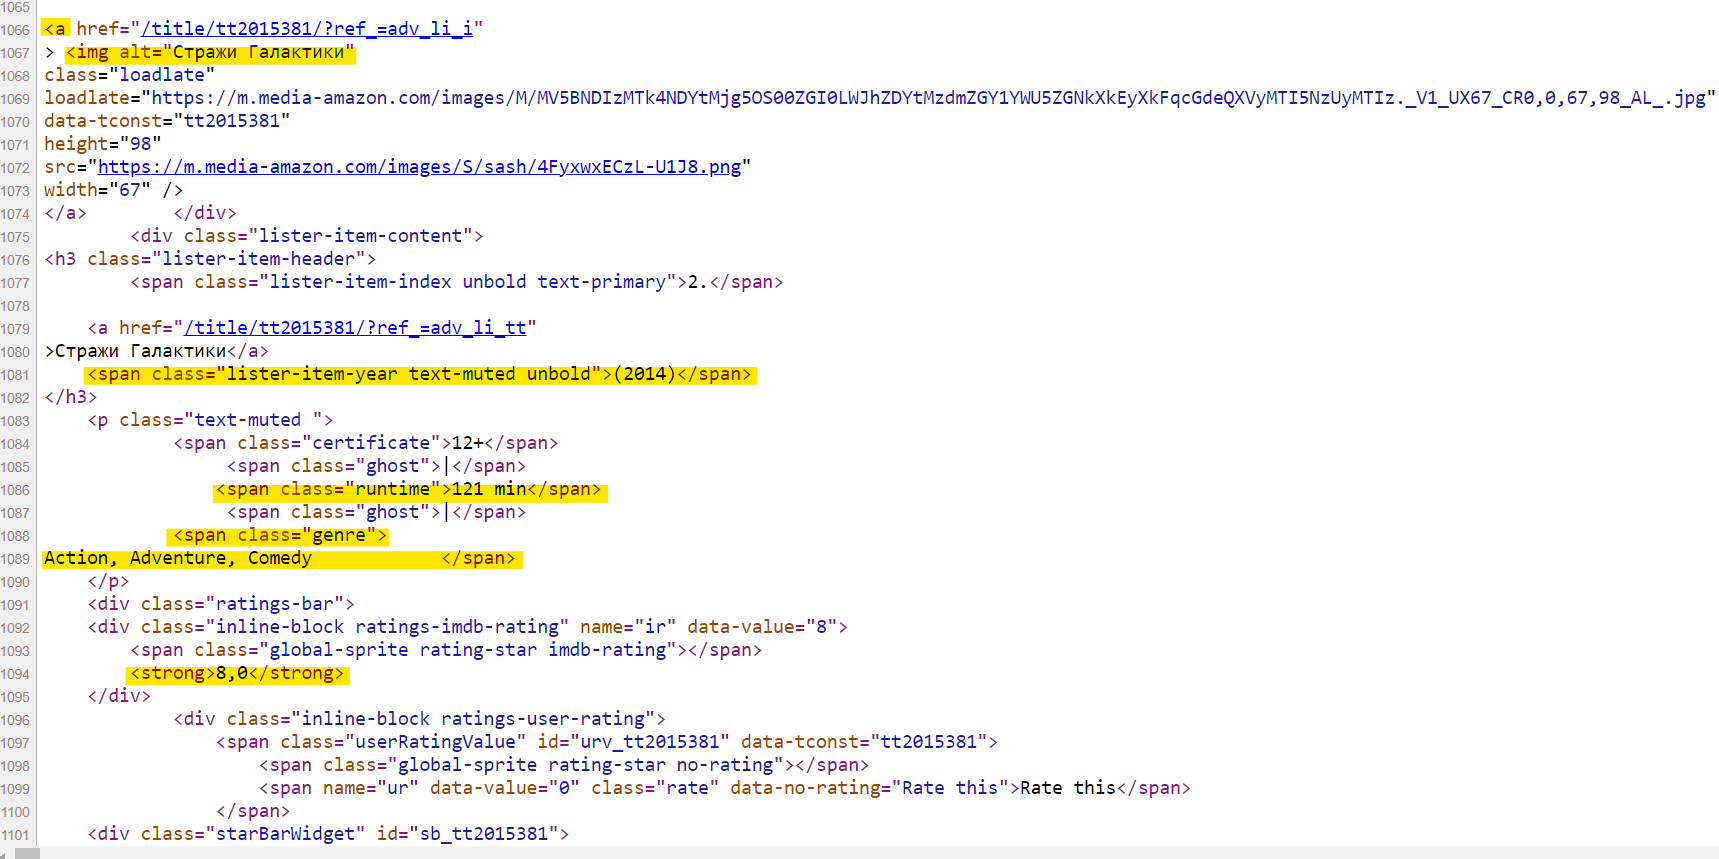

In [5]:
# Вынесем отдельным блоком функцию для забора данных

headers = {"Accept-Language": "en-US,en;q=0.5"}

def get_movie_data(url):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # находим все элементы div с классом lister-item mode-advanced на странице
    movie_data = soup.find_all('div', class_='lister-item mode-advanced')

    movie_list = []
    for data in movie_data:
        
       
        # создаем пустой словарь movie_dict и добавляем данные по переменным, которые ищем по тегам
        movie_dict = {}
        movie_dict['Movie Name'] = data.h3.a.text
        movie_dict['Year of Release'] = data.h3.find('span', class_='lister-item-year').text.strip('()').strip('II) (')
        movie_dict['Runtime'] = data.find('span', class_='runtime').text.strip('min')
        movie_dict['Genre'] = data.find('span', class_="genre").text.strip()
        movie_dict['Movie Rating'] = data.strong.text
        
        #добавляем в словарь metascore фильма, который находится внутри тега span с классом metascore, если такой тег существует
        movie_dict['Metascore of Movie'] = data.find('span', class_='metascore').text.strip() if data.find('span', class_='metascore') else '0'
        
        
        value = data.find_all('span', attrs = {'name': 'nv'})
        
        # добавляем в словарь количество голосов за фильм и заменяет запятые на пустые строки, чтобы далее анализировать данные 
        vote = value[0]
        movie_dict['Votes'] = vote.text.replace(',', '')
        #сохраняем в переменную grosses значение второго элемента из value, если такой элемент существует, иначе оставляем пустую строку
        grosses = value[1].text if len(value) >1 else ''
        movie_dict['Gross'] = grosses if grosses else ''
        
        
        #добавляем в словарь описание к фильму
        description = data.find_all('p', class_='text-muted')
        movie_dict['Description'] = description[-1].text.strip() if description else ''
        
        #добавляем словарь  в список movie_list
        movie_list.append(movie_dict)

    return movie_list

In [6]:
# Применяем функцию для каждой страницы с данными и сохрняем результаты сначала в лист, потом преобразуем в датафрейм

urls = ['https://www.imdb.com/search/title/?groups=top_1000&start={}&ref_=adv_nxt'.format(start) for start in range(1, 1001, 50)]
movie_list = []
for url in urls:
    movie_list += get_movie_data(url)

df = pd.DataFrame(movie_list)

In [7]:
df.head()

,Movie Name,Year of Release,Runtime,Genre,Movie Rating,Metascore of Movie,Votes,Gross,Description
0,Spider-Man: Across the Spider-Verse,2023,140,"Animation, Action, Adventure",9.1,86,54090,#15,"Miles Morales catapults across the Multiverse,..."
1,John Wick: Chapter 4,2023,169,"Action, Crime, Thriller",8.0,78,191636,,John Wick uncovers a path to defeating The Hig...
2,Guardians of the Galaxy Vol. 3,2023,150,"Action, Adventure, Comedy",8.2,64,157604,#160,"Still reeling from the loss of Gamora, Peter Q..."
3,Spider-Man: Into the Spider-Verse,2018,117,"Animation, Action, Adventure",8.4,87,572157,$190.24M,Teen Miles Morales becomes the Spider-Man of h...
4,Top Gun: Maverick,2022,130,"Action, Drama",8.3,78,591592,$718.73M,"After thirty years, Maverick is still pushing ..."


In [8]:
# сохраним датафрейм в CSV для последующего анализа
df.to_csv('IMDbData.csv')